In [1]:
import sys
sys.path.append("../")

In [46]:
import os
import json

import numpy as np
import mlflow

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.callbacks import EarlyStopping

from src.utils import (
    mlflow_credential_path,
    get_conv2d_metadata,
    mean_squared_error,
)

import matplotlib.pyplot as plt

## set environment variables

In [3]:
# read mlflow credentials
with open(mlflow_credential_path, "r") as f:
    credentials = json.load(f)

In [4]:
# set mlflow accounts
os.environ["MLFLOW_TRACKING_USERNAME"] = credentials["MLFLOW_TRACKING_USERNAME"]
os.environ["MLFLOW_TRACKING_PASSWORD"] = credentials["MLFLOW_TRACKING_PASSWORD"]

In [5]:
# set gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## image data generator

In [16]:
class ImageGenerator:
    def __init__(self):
        pass
    
    @staticmethod
    def read_iamge(path: str):
        buffer = tf.io.read_file(path)
        image = tf.io.decode_jpeg(buffer)
        return image

    @staticmethod
    def resize_image(image: tf.Tensor, size: tuple):
        # force image shape to be squared (aspect_ratio)
        resized = tf.image.resize(
            image,
            size=size,
            method="bilinear",
            preserve_aspect_ratio=False
        )
        return resized
    
    def get_dataset(self,
                    paths: list,
                    scores: list,
                    batch_size: int = 64,
                    image_shape: tuple = (224, 224),
                    num_parallel: int = tf.data.AUTOTUNE,
                    shuffle: bool = False):
        
        scores = tf.reshape(scores, (-1, 1))
        dataset = tf.data.Dataset.from_tensor_slices((paths, scores))
        
        # shuffle for trainig phase     
        if shuffle:
            buffer_size = len(paths)
            dataset = dataset.shuffle(buffer_size)
            
        # read & resize images
        dataset = dataset.map(
            lambda x, y: [self.read_iamge(x), tf.cast(y, "float32")],
            num_parallel_calls=num_parallel,
        )
        dataset = dataset.map(
            lambda x, y: [self.resize_image(x, image_shape), y],
            num_parallel_calls=num_parallel,
        )

        # to batch dataset
        dataset = dataset.batch(batch_size)
        
        return dataset

In [17]:
(X_train, y_train), (X_valid, y_valid) = get_conv2d_metadata()

In [18]:
image_gen = ImageGenerator()

In [19]:
train_dataset = image_gen.get_dataset(
    paths=X_train,
    scores=y_train,
    batch_size=64,
    image_shape=(224, 224),
    shuffle=True,
)

In [20]:
images, scores = next(iter(train_dataset))

In [21]:
images.shape

TensorShape([64, 224, 224, 3])

In [22]:
scores.shape

TensorShape([64, 1])

Text(0.5, 0.75, 'Sample Images and Scores')

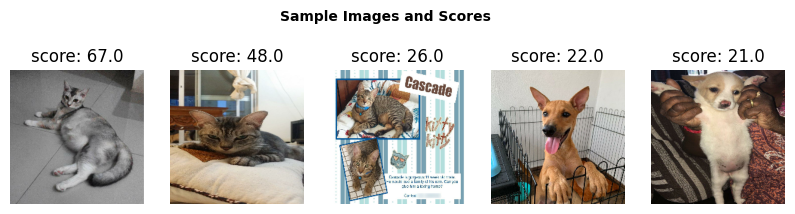

In [35]:
# draw sample images
num_draw = 5
fig, ax_arr = plt.subplots(1, num_draw, figsize=(10, 5))
for i in range(num_draw):
    ax = ax_arr[i]
    ax.imshow(tf.cast(images[i], "uint8"))
    ax.axis("off")
    ax.set_title(f"score: {scores[i][0]}")

fig.suptitle("Sample Images and Scores", weight="bold", size=10, y=0.75)

## conv regression

In [48]:
def get_keras_conv2d():
    """A function to build an instance of a Keras conv2d model."""
    inputs = Input(shape=(224, 224, 3))
    x = inputs
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPool2D(2)(x)
    
    x = Conv2D(filters=34, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPool2D(3)(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPool2D(3)(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [50]:
model = get_keras_conv2d()

In [51]:
train_dataset = image_gen.get_dataset(
    paths=X_train,
    scores=y_train,
    batch_size=64,
    image_shape=(224, 224),
    shuffle=True,
)

valid_dataset = image_gen.get_dataset(
    paths=X_valid,
    scores=y_valid,
    batch_size=64,
    image_shape=(224, 224),
    shuffle=False,
)

In [52]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=5
    ),
]

In [54]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=callbacks,
)

Epoch 1/30
140/140 [==============================] - 11s 82ms/step - loss: 757.1731 - root_mean_squared_error: 27.5168 - val_loss: 1209.2100 - val_root_mean_squared_error: 34.7737
Epoch 2/30
140/140 [==============================] - 7s 46ms/step - loss: 754.8471 - root_mean_squared_error: 27.4745 - val_loss: 1124.7502 - val_root_mean_squared_error: 33.5373
Epoch 3/30
140/140 [==============================] - 7s 47ms/step - loss: 728.4038 - root_mean_squared_error: 26.9890 - val_loss: 1237.7739 - val_root_mean_squared_error: 35.1820
Epoch 4/30
140/140 [==============================] - 7s 47ms/step - loss: 748.6376 - root_mean_squared_error: 27.3612 - val_loss: 1161.4663 - val_root_mean_squared_error: 34.0803
Epoch 5/30
140/140 [==============================] - 7s 46ms/step - loss: 749.0143 - root_mean_squared_error: 27.3681 - val_loss: 1237.9557 - val_root_mean_squared_error: 35.1846
Epoch 6/30
140/140 [==============================] - 7s 47ms/step - loss: 738.3364 - root_mean_squ

In [ ]:
def fit_keras_conv2d():
    """
    A function to train a Keras conv2d model.
    """
    train_generator, validation_generator = load_tf_datasets()
    logging.log(logging.INFO, "Loaded the data generators")

    model = get_keras_conv2d()

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                                  patience=5)]

    logging.log(logging.INFO, "Started training...")
    model.fit(train_generator, validation_data=validation_generator, epochs=30,
              callbacks=callbacks, verbose=2)

    return model
